In [3]:
import math
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt

In [4]:
path = '/Users/jonniebarnsley/Code/phd/Postprocessing/Pliocene_control/AIS_PPE_control_ensemble_SLC.csv'
ppe = pd.read_csv('/Users/jonniebarnsley/code/phd/Postprocessing/Pliocene_control/PPE_design.csv')

data = pd.read_csv(path, index_col=0, dtype=float)

data = data[data.index < 10_000]

weird_runs = [20, 34, 52, 62, 70, 74, 78, 87, 103, 114]

end_slc = data[data.index == 9990]

min_slc = end_slc.values[0].min()
max_slc = end_slc.values[0].max()
median_slc = np.median(end_slc.values[0])
mean_slc = np.mean(end_slc.values[0])
std_slc = np.std(end_slc.values[0])

print(f'min: {min_slc:.2f}')
print(f'max: {max_slc:.2f}')
print(f'median: {median_slc:.2f}')
print(f'mean: {mean_slc:2f} ± {std_slc:2f}')

total = len(end_slc.T)
slc_gt0 = (end_slc > 0).sum().sum()
pct_gt0 = round(100*slc_gt0/total, 1)

slc_lt0 = total - slc_gt0
pct_lt0 = 100-pct_gt0

print(slc_gt0, f'exhibit sea level rise ({pct_gt0}%)')
print(slc_lt0, f'exhibit sea level fall ({pct_lt0}%)')


min: -15.66
max: 23.50
median: -3.79
mean: -1.485944 ± 9.063442
38 exhibit sea level rise (31.7%)
82 exhibit sea level fall (68.3%)


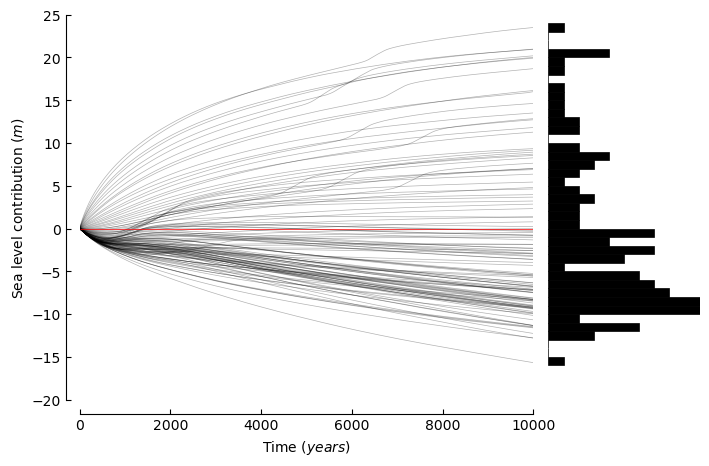

In [5]:
font = {'weight' : 'normal',
        'size'   : 10}

matplotlib.rc('font', **font)
color='black'
fig, ax = plt.subplots(ncols=2, figsize=(8, 5), sharey=True, width_ratios=[3, 1])

ax[0].plot(
    data, 
    linewidth=0.5, 
    c=color, 
    alpha=0.3,
    #linestyle='dashdot'
    )

bins = np.arange(-16, 25, 1)
ax[1].hist(
    end_slc.T,
    bins = bins,
    orientation='horizontal',
    color='black',
    alpha=1,
    edgecolor='black',
    linewidth=0.5,
)

# for dir in ['top', 'bottom', 'left', 'right']:
#     ax[1].spines[dir].set_color('none')
# ax[1].tick_params(color='none')

ax[0].set_xlim([0, 10_000])
ax[0].set_ylim([-20, 25])
ax[0].set_xlabel('Time ($years$)')
ax[0].set_ylabel('Sea level contribution ($m$)')
#ax[0].grid(which='major', color='black', alpha=0.2)
#ax[0].grid(which='minor', color='black', linestyle=':', alpha=0.1)
#ax[0].minorticks_on()
#ax[0].grid(color='black', alpha=0.05)
ax[1].set_axis_off()
ax[0].spines['right'].set_color('none')
ax[0].spines['top'].set_color('none')
ax[0].spines['left'].set_position(('outward', 10))
#ax[0].spines['left'].set_color('none')
ax[0].spines['bottom'].set_position(('outward', 10))
ax[0].tick_params(axis='both', direction='in')
#ax[0].set_facecolor('whitesmoke')
for dir in ['bottom', 'right', 'left']:
    ax[1].spines[dir].set_position(('outward', 10))
    ax[1].spines[dir].set_color('none')
ax[1].tick_params(axis='y', color='none')
ax[1].tick_params(axis='x', direction='in')
ax[1].xaxis.tick_top()
ax[1].spines['top'].set_position(('outward', 10))
ax[1].set_xlim([0, 10])
ax[1].set_xticks([0, 2, 4, 6, 8, 10])
ax[1].set_xlabel('Frequency')
ax[1].xaxis.set_label_position('top')
ax[0].hlines(0, 0, 10_000, lw=0.5, color='red')
#ax[1].grid(alpha=0.2)
fig.subplots_adjust(wspace=0.05)

#rect = matplotlib.patches.Rectangle((0, -3), 10_000, 23, alpha=0.1, facecolor='yellow', edgecolor='red', linewidth=10)
#ax[0].add_patch(rect)


plt.savefig('../plots/svg/control_ensemble.svg', format='svg')
plt.savefig('../plots/png/control_ensemble.png', format='png')

In [6]:
parameter_data = pd.read_csv('/Users/jonniebarnsley/Code/phd/Emulation/Pliocene/Pliocene data.csv')
parameter_values = parameter_data[['expNum', 'gamma0', 'UMV', 'LRP', 'PDDi', 'WeertC', 'model']]
df = pd.DataFrame(
    {
        'expNum': map(int, data.T.index),
        'gamma0': parameter_data['gamma0'],
        'UMV': parameter_data['UMV'],
        'PDDi': parameter_data['PDDi'],
        #'WeertC': parameter_data['WeertC'],
        'slc_10k_minus_control': parameter_data['slc_10k_minus_control'],
        'Plio_SLC_10k': parameter_data['slc_10k_minus_control']+0.68,
        'ctrle_SLC_10k': data.loc[data.index == 9990].values[0],
        'main_minus_ctrle': parameter_data['main_minus_ctrle_10k']
    }
    )

df['Plio_SLC_10k'] = pd.to_numeric(df['Plio_SLC_10k'], errors='coerce')
df['ctrle_SLC_10k'] = pd.to_numeric(df['ctrle_SLC_10k'], errors='coerce')

df['Plio_minus_ctrle'] = df['Plio_SLC_10k'] - df['ctrle_SLC_10k']
df = df.dropna()
df = df[~df['expNum'].isin(weird_runs)]

df['diff'] = df['Plio_minus_ctrle'] - df['main_minus_ctrle']
# Set display options to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Display the entire DataFrame
print(df.loc[[53, 82, 100, 105], ['expNum', 'Plio_SLC_10k', 'ctrle_SLC_10k', 'main_minus_ctrle', 'Plio_minus_ctrle', 'diff']])

# Reset display options (if needed) to default values
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

     expNum  Plio_SLC_10k  ctrle_SLC_10k  main_minus_ctrle  Plio_minus_ctrle  \
53       54     -2.319953      -9.167687          5.483871          6.847734   
82       83      5.895681      -0.010666          4.527973          5.906347   
100     101      7.407920       0.792023          5.236257          6.615897   
105     106     10.152075       2.334925          6.436985          7.817150   

         diff  
53   1.363864  
82   1.378374  
100  1.379639  
105  1.380165  


In [7]:
df[['expNum', 'Plio_SLC_10k', 'ctrle_SLC_10k', 'main_minus_ctrle', 'Plio_minus_ctrle']]

,expNum,Plio_SLC_10k,ctrle_SLC_10k,main_minus_ctrle,Plio_minus_ctrle
8,9,-1.476405,-9.842538,11.538679,8.366133
24,25,-3.436372,-2.875373,2.610751,-0.560999
37,38,8.074032,-1.837980,8.740385,9.912011
38,39,0.050972,-8.473068,7.437156,8.524039
39,40,-10.452117,-6.747255,-0.209927,-3.704862
40,41,8.694965,5.435137,5.130587,3.259828
43,44,-1.239041,-2.964387,4.327182,1.725346
46,47,7.040482,-1.852737,8.247598,8.893219
47,48,8.869153,-2.569999,10.202889,11.439152
53,54,-2.319953,-9.167687,5.483871,6.847734


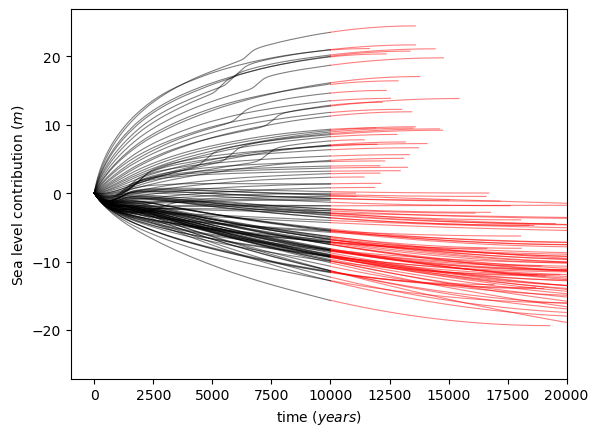

In [8]:
#fig, ax = plt.subplots(len(completed), figsize=(3, 100))
#fig.tight_layout()

fig, ax = plt.subplots()

years = np.arange(0, 10020, 30)

def quadratic(x, a, b, c):
    return a*(x-b)**2 + c

def asymptotic(x, a, b, n):
    return a * x ** n  / (x ** n + b)

for i, run_num in enumerate(data):
    run = data[run_num]
    ax.plot(years, run, c='black', alpha=0.5, lw=0.8)
    ax.set_ylabel('Sea level contribution ($m$)')
    ax.set_xlabel('time ($years$)')

    if int(run_num) not in weird_runs:
        start_year=5000
    else:
        start_year=8000
    fit_years = np.arange(start_year, 9990, 30)
    fit_data = run[run.index > start_year]

    poly = np.polyfit(fit_years, fit_data, deg=2)
    a, b, c = poly
    end_year = -b/(2*a)
    if end_year < 10_000:
        continue

    #asymp, _ = curve_fit(asymptotic, fit_years, fit_data)

    years_extrap = np.linspace(10_000, end_year, 100)
    extrapolation = np.polyval(poly, years_extrap)

    ax.plot(years_extrap, extrapolation, c='red', alpha=0.5, lw=0.8)
    ax.set_xlim([-1000, 20000])

    #popt, pcov = curve_fit(asymptotic, fit_years, fit_data, p0=[1., 5000., 1.])

    fig.savefig('../plots/png/control_ensemble_extrap.png', format='png')

In [9]:
df = data.T
df.index = range(120)

df = pd.concat([parameter_values, df], axis=1)

[9618.882299425968, 14477.336760227674, 21005.34363839212, 86984.00071113347, 159188.54144055457, 471264.2917076337]


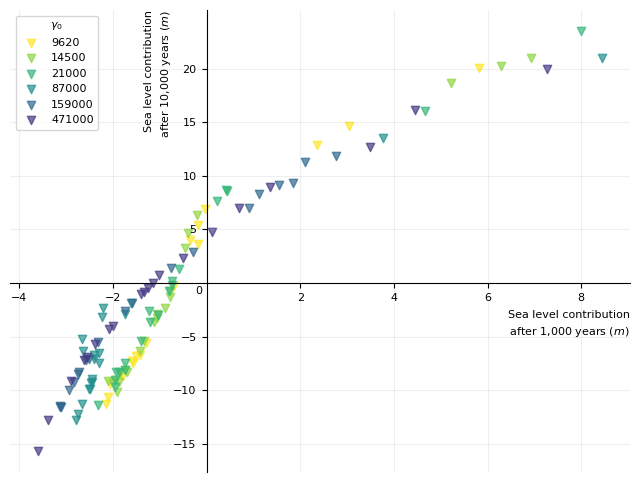

In [10]:
font = {'size': 8}
matplotlib.rc('font', **font)

fig, ax = plt.subplots(figsize=(8, 6))

unique_gamma_values = sorted(df['gamma0'].unique())
print(unique_gamma_values)
colors = cm.viridis_r([i / len(unique_gamma_values) for i in range(len(unique_gamma_values))])
gamma_color_map = {gamma_value: colors[i] for i, gamma_value in enumerate(unique_gamma_values)}

#im = ax.scatter(nwparams[990.0], nwparams[9990.0], c=nwparams['gamma0'], cmap='viridis')

def round_to_three_significant_figures(number):
    if number != 0:
        return int(round(number, 3 - int(math.floor(math.log10(abs(number)))) - 1))
    else:
        return 0.0

for i, gamma_value in enumerate(unique_gamma_values):
    gamma_df = df[df['gamma0'] == gamma_value]
    ax.scatter(
        gamma_df[990.0], 
        gamma_df[9990.0], 
        color=gamma_color_map[gamma_value], 
        label=f'{round_to_three_significant_figures(gamma_value)}',
        marker='v',
        alpha=0.7
        )

ax.spines['bottom'].set_position('zero')
ax.spines['left'].set_position('zero')
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.grid(alpha=0.2)
legend = ax.legend(title='$\gamma_0$', loc='upper left')
#legend.set_title('Lines', prop={'size': 12})
#fig.colorbar(im)
ax.set_xticks([-4, -2, 2, 4, 6, 8])
ax.set_yticks([-15, -10, -5, 5, 10, 15, 20])

ax.set_xlabel('Sea level contribution\n after 1,000 years ($m$)', loc='right', labelpad=5, linespacing=1.5)
#ax.set_ylabel('SLC at 10,000 years', labelpad=-26, y = 1.02, rotation=0)
ax.set_ylabel('Sea level contribution\n after 10,000 years ($m$)', loc='top', labelpad=0, linespacing=1.5)

ax.text(-0.25, -1, '0')

plt.savefig('../plots/svg/transientVsequilibrium.svg', format='svg')
plt.savefig('../plots/png/transientVsequilibrium.png', format='png')

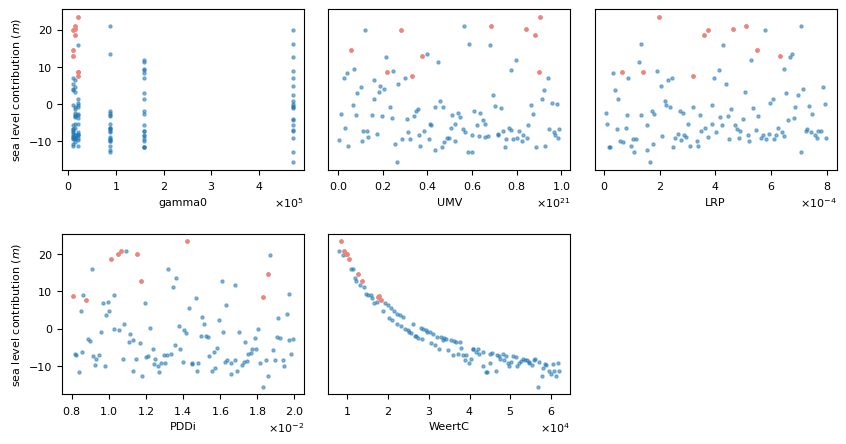

In [11]:
import matplotlib.ticker as mticker
from itertools import product

parameters = ['gamma0', 'UMV', 'LRP', 'PDDi', 'WeertC']
weird_runs = np.array(weird_runs)

ticks = {
    'gamma0': [0, 2e5, 4e5, ]
}

fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(10, 5))
for param, ax in zip(parameters, axes.flatten()):
    y = end_slc.values[0]
    x = parameter_values[param].values

    ax.scatter(x, y, s=5, alpha=0.5)
    ax.scatter(x[weird_runs-1], y[weird_runs-1], c='salmon', s=5, alpha=1)
    ax.set_xlabel(param)
    formatter = mticker.ScalarFormatter(useMathText=True)
    ax.xaxis.set_major_formatter(formatter)
    ax.ticklabel_format(style='sci', scilimits=(-2, 2))

# axes[0][0].set_ylabel('sea level contribution ($m$)')
# axes[1][0].set_ylabel('sea level contribution ($m$)')

for i, j in product(range(3), range(2)):
    if i == 0:
        axes[j][i].set_ylabel('sea level contribution ($m$)')
    else:
        axes[j][i].tick_params(axis='y', which='both', left=False, labelleft=False)
        # axes[i][j].set_yticklabels([])

axes[1][2].set_axis_off()
fig.subplots_adjust(hspace=0.4, wspace=0.1)

plt.savefig('../plots/svg/sensitivity_main.svg', format='svg')
plt.savefig('../plots/png/sensitivity_main.png', format='png')

1       6.225787
2      16.312585
3      10.733773
4       6.058107
5      -4.943914
         ...    
116          NaN
117     1.566160
118     1.127536
119    -2.916010
120   -16.671259
Name: 9990, Length: 120, dtype: float64


(array([ 4., 12., 21., 28., 14., 13.,  7.,  5.,  5.,  2.]),
 array([-16.67125899, -12.26190932,  -7.85255964,  -3.44320997,
          0.9661397 ,   5.37548938,   9.78483905,  14.19418872,
         18.60353839,  23.01288807,  27.42223774]),
 <BarContainer object of 10 artists>)

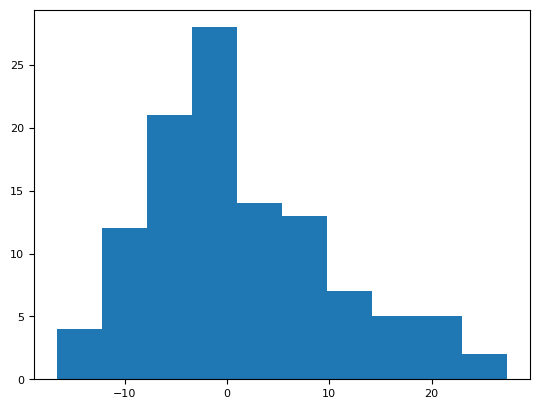

In [12]:
pliocene_slc = pd.read_csv('/Users/jonniebarnsley/code/phd/Postprocessing/Pliocene_control/AIS_PPE_SLC.csv', index_col=0)
print(pliocene_slc.iloc[-1])

plt.hist(pliocene_slc.iloc[-1])

001     3.967440
002    11.810203
003     7.002231
004    -4.300125
005    -9.267447
         ...    
116    12.714530
117     0.226333
118     3.678539
119    -7.500984
120   -11.315816
Name: 9990.0, Length: 120, dtype: float64


(array([ 4., 33., 23., 22.,  8.,  9.,  7.,  5.,  3.,  6.]),
 array([-1.56611058e+01, -1.17451977e+01, -7.82928959e+00, -3.91338150e+00,
         2.52660112e-03,  3.91843470e+00,  7.83434279e+00,  1.17502509e+01,
         1.56661590e+01,  1.95820671e+01,  2.34979752e+01]),
 <BarContainer object of 10 artists>)

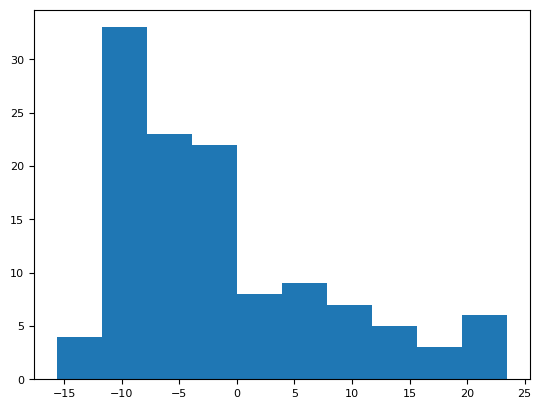

In [13]:
print(data.iloc[-1])
plt.hist(data.iloc[-1])

In [68]:
from sklearn.neighbors import KernelDensity

plio_minus_ctrl = pliocene_slc.iloc[-1].values-data.iloc[-1].values

calibrated = [x for x in plio_minus_ctrl if x>-3]
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(calibrated)
x_plot = np.linspace(-7, 12, 100)
y_plot = kde.score_samples(x_plot)

fig, ax = plt.subplots()

bins = bins=np.arange(-6, 12, 1)

hist, edges = np.histogram(plio_minus_ctrl, bins=bins, density=True)

for i in range(len(edges) - 1):
    alpha = 0.5 if edges[i] < -3 else 1.0
    ax.bar(edges[i], hist[i], width=np.diff(edges)[i], alpha=alpha, color='cornflowerblue')

ax.plot(x_plot, y_plot)


# alphas = np.where(edges[:-1] < -3, 0.5, 1.0)
# ax.bar(edges[:-1]+0.5, hist, width=np.diff(edges), alpha=alphas, color='blue', edgecolor='black')

# for bar in ax.containers[0]:
#     x = bar.get_x() + 0.5 * bar.get_width()

#     # set bar color based on x
#     if x < -3:
#         bar.set_color(('cornflowerblue', 0.5))
#     elif x > 20:
#         bar.set_color('red')
#     else:
#         bar.set_color('green')

ValueError: Expected 2D array, got 1D array instead:
array=[-7.         -6.80808081 -6.61616162 -6.42424242 -6.23232323 -6.04040404
 -5.84848485 -5.65656566 -5.46464646 -5.27272727 -5.08080808 -4.88888889
 -4.6969697  -4.50505051 -4.31313131 -4.12121212 -3.92929293 -3.73737374
 -3.54545455 -3.35353535 -3.16161616 -2.96969697 -2.77777778 -2.58585859
 -2.39393939 -2.2020202  -2.01010101 -1.81818182 -1.62626263 -1.43434343
 -1.24242424 -1.05050505 -0.85858586 -0.66666667 -0.47474747 -0.28282828
 -0.09090909  0.1010101   0.29292929  0.48484848  0.67676768  0.86868687
  1.06060606  1.25252525  1.44444444  1.63636364  1.82828283  2.02020202
  2.21212121  2.4040404   2.5959596   2.78787879  2.97979798  3.17171717
  3.36363636  3.55555556  3.74747475  3.93939394  4.13131313  4.32323232
  4.51515152  4.70707071  4.8989899   5.09090909  5.28282828  5.47474747
  5.66666667  5.85858586  6.05050505  6.24242424  6.43434343  6.62626263
  6.81818182  7.01010101  7.2020202   7.39393939  7.58585859  7.77777778
  7.96969697  8.16161616  8.35353535  8.54545455  8.73737374  8.92929293
  9.12121212  9.31313131  9.50505051  9.6969697   9.88888889 10.08080808
 10.27272727 10.46464646 10.65656566 10.84848485 11.04040404 11.23232323
 11.42424242 11.61616162 11.80808081 12.        ].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [58]:
parameter_values['Pliocene'] = pliocene_slc.iloc[-1].values
parameter_values['Control'] = data.iloc[-1].values
parameter_values['Plio_minus_ctrl'] = parameter_values['Pliocene'] - parameter_values['Control']

/var/folders/d9/3tqzv4xj1sx00nng1hd597500000gn/T/ipykernel_2590/213438634.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameter_values['Pliocene'] = pliocene_slc.iloc[-1].values
/var/folders/d9/3tqzv4xj1sx00nng1hd597500000gn/T/ipykernel_2590/213438634.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameter_values['Control'] = data.iloc[-1].values
/var/folders/d9/3tqzv4xj1sx00nng1hd597500000gn/T/ipykernel_2590/213438634.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

,expNum,gamma0,UMV,LRP,PDDi,WeertC,model,Pliocene,Control,Plio_minus_ctrl
0,1,9618.882299,2.057769e+20,0.000716,0.019590,22300.784043,cosmos,6.225787,3.967440,2.258347
1,2,159188.541441,7.970285e+20,0.000527,0.016819,13110.001766,cosmos,16.312585,11.810203,4.502383
2,3,159188.541441,2.365918e+19,0.000396,0.011979,16585.219430,cosmos,10.733773,7.002231,3.731542
3,4,471264.291708,6.490640e+20,0.000662,0.013550,31568.739031,cosmos,6.058107,-4.300125,10.358232
4,5,159188.541441,3.211577e+20,0.000102,0.018149,39836.391217,cosmos,-4.943914,-9.267447,4.323533
...,...,...,...,...,...,...,...,...,...,...
115,116,471264.291708,2.146118e+20,0.000667,0.016084,12164.391333,hadcm3,NaN,12.714530,NaN
116,117,21005.343638,9.570742e+20,0.000597,0.012239,28079.558275,hadcm3,1.566160,0.226333,1.339827
117,118,9618.882299,9.249898e+20,0.000039,0.009879,22846.378123,hadcm3,1.127536,3.678539,-2.551003
118,119,21005.343638,3.116500e+20,0.000743,0.012031,51296.826880,hadcm3,-2.916010,-7.500984,4.584974


<Axes: ylabel='Density'>

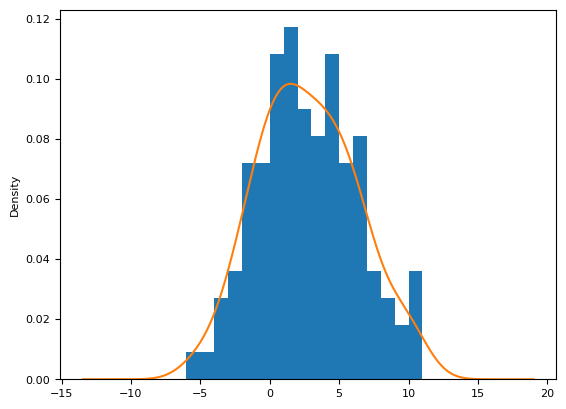

In [63]:
parameter_values['Plio_minus_ctrl'].plot(kind='hist', bins=bins, density=True)
parameter_values['Plio_minus_ctrl'].plot(kind='kde')

In [69]:
kde = KernelDensity().fit(plio_minus_ctrl)

ValueError: Expected 2D array, got 1D array instead:
array=[ 2.25834703  4.50238266  3.73154241 10.35823176  4.32353266  5.06076326
  9.15763226  8.65573759  7.00932621  4.96670429  0.75167857  6.84564832
 -0.59222898  1.14941919  4.17928993  0.03984248  5.23991592         nan
  8.87714677  1.06967398 10.88586971         nan  4.6643036  -0.64381219
 -1.90538256  4.08054263  9.29149984         nan -2.81931636  6.67835259
  5.97225749         nan  1.86577749  0.39364634  1.33308819         nan
  2.13602559  8.52920032  7.13902653 -4.97943195  1.87973952  3.02214524
  4.11838355  0.36327772  3.32319087  1.30276179  7.31760231 10.04190509
 -2.35943672  2.00156477  6.54791423 -1.06834778  6.48532469  6.49421399
  6.14145592  0.78321711 -3.27202113  5.42827719  0.11252187 -0.66270356
 -0.64946108 -0.5485747  -0.5441103   4.52949249 -1.28059461  6.00186912
  2.87357234  2.24430905  4.22536467 -0.51911888  0.50941306  1.2686788
  3.40086398 -1.39266095  5.37207409  2.09985394  0.4960618  -1.85590285
  2.60234345 -1.69971187 -3.03936507 -1.6343313   4.52741777  3.38944323
  1.90705361  1.0174988  -2.40412718         nan         nan  0.07632962
  0.13143606  4.13482453 -3.86142483  3.51172924  2.55758585  6.72388153
  5.48718633  3.38058566  5.54795719  3.19240224  5.23281833  1.73218975
 -0.0148381   3.86407756 10.31013031  6.43597087 -1.01503042  1.45191298
  0.34617036  2.47647561  1.72151962  2.89626498  0.30069376         nan
  7.72206458         nan  1.33982664 -2.5510032   4.58497387 -5.35544327].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

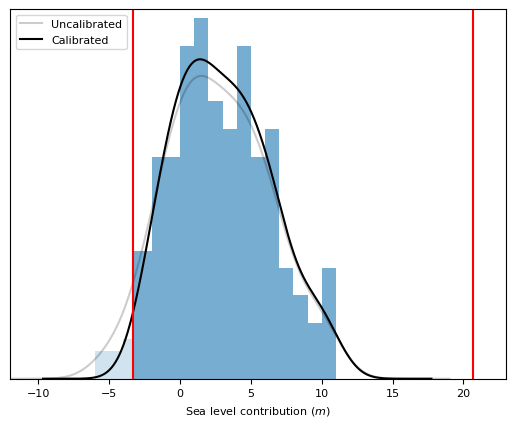

In [201]:
fig, ax = plt.subplots()

bins=np.linspace(-3.3, 20.7, 20)
diff = bins[1]-bins[0]
new_min_bin = bins[0]-3*diff

bins = np.arange(new_min_bin, 20.7+diff, diff)
bins = [-17, -16, -15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3.3, -2, -1, 0, 1, 2, 3, 4,\
         5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 20.7, 22, 23, 24, 25, 26, 27, 28]
n, bins, patches = ax.hist(parameter_values['Plio_minus_ctrl'], bins=bins, density=True, alpha=0.6)

#ax.hist(parameter_values['Pliocene'], bins=bins, alpha=0.1, color='green', density=True)

#ax.hist(parameter_values['Plio_minus_ctrl'], bins=np.linspace(-6, -3.3, 3))

# Set alpha conditionally for bars with x coordinate less than -3
for i in range(len(bins)-1):
    if bins[i] < -3.3:
        patches[i].set_alpha(0.2)

parameter_values['Plio_minus_ctrl'].plot.kde(color='black', label='Uncalibrated', alpha=0.2)
parameter_values[parameter_values['Plio_minus_ctrl']>-3]['Plio_minus_ctrl'].plot.kde(color='black', label='Calibrated')


ax.legend(loc = 'upper left')
# for pos in ['left', 'top', 'right', 'bottom']:
#     ax.spines[pos].set_color('none')
#ax.grid(axis='both', color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.5) 
ax.get_yaxis().set_visible(False)
ax.set_xlim(-12, 23)
ax.set_ylim(0, 0.12)

ax.vlines(-3.3, 0, 0.12, color='red')
ax.vlines(20.7, 0, 0.12, color='red')

ax.set_xlabel('Sea level contribution ($m$)')

plt.savefig('../plots/svg/pliominusctrl.svg', format='svg')
plt.savefig('../plots/png/pliominusctrl.png', format='png')

In [203]:
min = parameter_values['Plio_minus_ctrl'].min()
max = parameter_values['Plio_minus_ctrl'].max()
mean = parameter_values['Plio_minus_ctrl'].mean()
sdt = parameter_values['Plio_minus_ctrl'].std()
median = parameter_values['Plio_minus_ctrl'].median()

print(min, max, mean, sdt, median, sep='\n')

-5.355443268738638
10.885869710873497
2.71590846284614
3.5718996406668784
2.4764756131523136


In [208]:
np.sum(parameter_values['Plio_minus_ctrl']>-3.3)

108

In [213]:
mask = parameter_values['Plio_minus_ctrl']>-3.3
calibrated = parameter_values['Plio_minus_ctrl'][mask]
print(calibrated.mean())
print(calibrated.std())
print(calibrated.median())

2.9227975872669485
3.3921051038233396
2.5799646521224275


In [214]:
parameter_values

,expNum,gamma0,UMV,LRP,PDDi,WeertC,model,Pliocene,Control,Plio_minus_ctrl
0,1,9618.882299,2.057769e+20,0.000716,0.019590,22300.784043,cosmos,6.225787,3.967440,2.258347
1,2,159188.541441,7.970285e+20,0.000527,0.016819,13110.001766,cosmos,16.312585,11.810203,4.502383
2,3,159188.541441,2.365918e+19,0.000396,0.011979,16585.219430,cosmos,10.733773,7.002231,3.731542
3,4,471264.291708,6.490640e+20,0.000662,0.013550,31568.739031,cosmos,6.058107,-4.300125,10.358232
4,5,159188.541441,3.211577e+20,0.000102,0.018149,39836.391217,cosmos,-4.943914,-9.267447,4.323533
...,...,...,...,...,...,...,...,...,...,...
115,116,471264.291708,2.146118e+20,0.000667,0.016084,12164.391333,hadcm3,NaN,12.714530,NaN
116,117,21005.343638,9.570742e+20,0.000597,0.012239,28079.558275,hadcm3,1.566160,0.226333,1.339827
117,118,9618.882299,9.249898e+20,0.000039,0.009879,22846.378123,hadcm3,1.127536,3.678539,-2.551003
118,119,21005.343638,3.116500e+20,0.000743,0.012031,51296.826880,hadcm3,-2.916010,-7.500984,4.584974


In [216]:
parameter_values.to_csv('../../Emulation/Pliocene/pliocene_minus_control.csv')

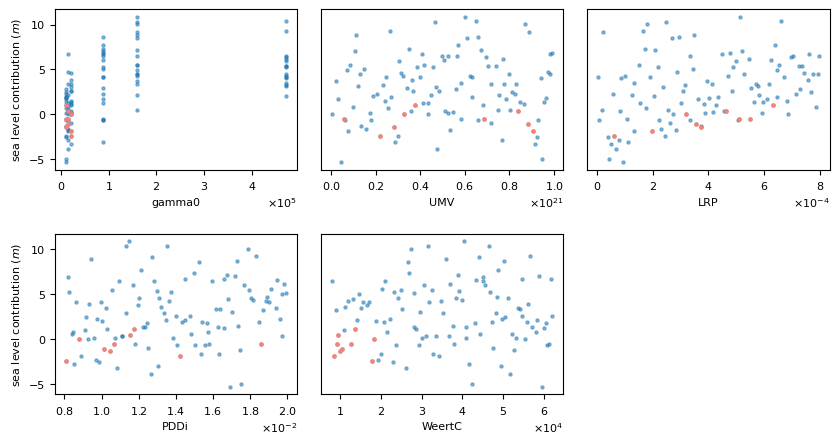

In [217]:


# ticks = {
#     'gamma0': [0, 2e5, 4e5, ]
# }

fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(10, 5))
for param, ax in zip(parameters, axes.flatten()):
    y = parameter_values['Plio_minus_ctrl'].values
    x = parameter_values[param].values

    ax.scatter(x, y, s=5, alpha=0.5)
    ax.scatter(x[weird_runs-1], y[weird_runs-1], c='salmon', s=5, alpha=1)
    ax.set_xlabel(param)
    formatter = mticker.ScalarFormatter(useMathText=True)
    ax.xaxis.set_major_formatter(formatter)
    ax.ticklabel_format(style='sci', scilimits=(-2, 2))

# axes[0][0].set_ylabel('sea level contribution ($m$)')
# axes[1][0].set_ylabel('sea level contribution ($m$)')

for i, j in product(range(3), range(2)):
    if i == 0:
        axes[j][i].set_ylabel('sea level contribution ($m$)')
    else:
        axes[j][i].tick_params(axis='y', which='both', left=False, labelleft=False)
        # axes[i][j].set_yticklabels([])

axes[1][2].set_axis_off()
fig.subplots_adjust(hspace=0.4, wspace=0.1)

plt.savefig('../plots/svg/sensitivity_main.svg', format='svg')
plt.savefig('../plots/png/sensitivity_main.png', format='png')